In [1]:
# imports
import numpy as np

import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

import cv2
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from collections import deque
import numpy as np
import argparse
import cv2
import time
%matplotlib inline


# Utility Functions
functions to help you run the notebook more easily

In [2]:
def show_image(image, grey=False):
    if grey:
        plt.imshow(image,cmap='gray', vmin = 0, vmax = 255)
    else:
        plt.imshow(image)

    plt.show()

# Section 1: Image Data and Manipulation

### Image loading
The process of images loading consists of multiple parts
1. Locating and reading the file bytes
2. decoding those bytes into the matrix format used for image manipulation

Images are encoded for effciency in storage and network transfer some algorithm do better compression than others for example JPEG

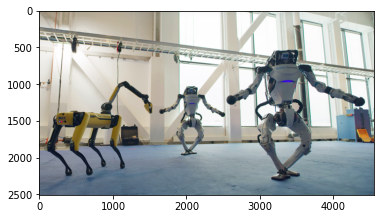

In [3]:
# load and show image 
image = cv2.imread('data/sample_image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #why this line ?
show_image(image)

### Check Image Properties
- The loaded image is a numpy array (matrix).
- img.shape indicates the number of pixels with three channels (since this is a RGB color image). 
- If the image is gray-scale, image shape contains only number of rows and columns.
- The data type of the image is uint8, i.e., 8 bit unsigned int (numbers from 0 to 255) as indicated by img.dtype.
- Minimum and maximum number in the matrix can be checked using the min and max functions.
- Total number of pixels can be obtained by img.size

**Question: does the image size when stored on disk = image.size ?**

In [5]:
print(type(image.shape))
print('image.shape', image.shape)
print('image.dtype', image.dtype) # 8 bit unsigned int (numbers from 0 to 255) as indicated by img.dtype.
print('image.min', image.min())
print('image.max', image.max())
print('image.size', image.size)

<class 'tuple'>
image.shape (2505, 4555, 3)
image.dtype uint8
image.min 0
image.max 255
image.size 34230825


In [6]:
# show 10x10 chunk of the first layer
image[0:10,0:10,0]

array([[145, 145, 144, 142, 142, 144, 151, 153, 156, 159],
       [142, 144, 143, 141, 145, 146, 150, 154, 156, 158],
       [145, 149, 147, 148, 149, 149, 149, 155, 155, 156],
       [145, 147, 149, 148, 150, 150, 151, 153, 151, 151],
       [148, 147, 150, 152, 153, 154, 155, 152, 148, 147],
       [148, 148, 148, 152, 152, 155, 153, 150, 147, 144],
       [150, 148, 149, 150, 153, 152, 153, 148, 146, 144],
       [151, 149, 149, 151, 150, 149, 149, 145, 146, 145],
       [154, 157, 153, 153, 153, 152, 149, 146, 144, 141],
       [154, 153, 153, 154, 156, 153, 149, 142, 141, 142]], dtype=uint8)

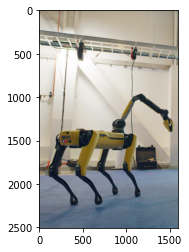

In [7]:
# crop the yellow robot
cropped_image = image[:,:1600,:]
show_image(cropped_image)

### Overlaying an image
Overlaying is basically replacing or averaging a pixel value with a new one

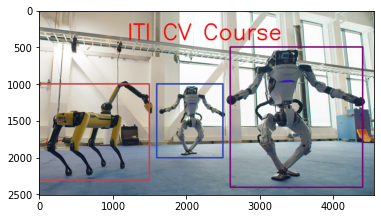

In [8]:
# write ITI CV Course on the top center of the image
image_draw = image.copy()



image_draw = cv2.putText(image_draw, 'ITI CV Course', (1200, 400),
                           cv2.FONT_HERSHEY_SIMPLEX, 
                   10, (255,0,0), 20, cv2.LINE_AA)
# draw a different color box on each robo

coords = [((0,1000),(1500,2300)),
         ((1600,1000),(2500,2000)),
         ((2600,500),(4400,2400))]
for top, bot in coords:
    color = np.random.randint(0,255,3).tolist()
    image_draw = cv2.rectangle(image_draw, top, bot, color, 20)


show_image(image_draw)

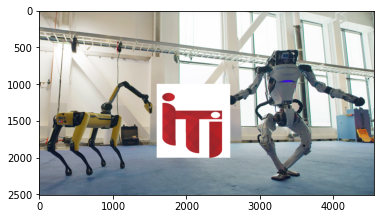

In [4]:
# load iti logo
logo = cv2.imread('data/iti_logo.jpg')
logo = cv2.cvtColor(logo, cv2.COLOR_RGB2BGR)

# resize logo to 300x300
w = 1000
h = 1000
x_offset = 1600
y_offset = 1000
logo_resized = cv2.resize(logo, (w, h))
# overlay image
overlayed_image = image.copy()
overlayed_image[y_offset:y_offset+h,x_offset:x_offset+w] = logo_resized
# overlayed_image = cv2.addWeighted(image, 1, logo, 0.5, 0.0)
show_image(overlayed_image)

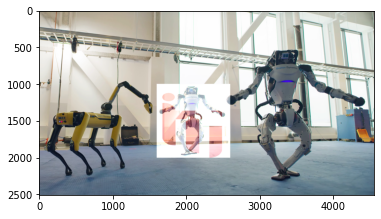

In [10]:
# overlay image
overlayed_image = image.copy()
overlay_weighted_section = overlayed_image[y_offset:y_offset+h,x_offset:x_offset+w]
overlay_weighted_section = cv2.addWeighted(overlay_weighted_section, 1, logo_resized, 0.5,1)
overlayed_image[y_offset:y_offset+h,x_offset:x_offset+w] = overlay_weighted_section
# overlayed_image = cv2.addWeighted(image, 1, logo, 0.5, 0.0)
show_image(overlayed_image)

# Section2: Color Spaces
Color spaces were created to fit different application for TV broadcast, Computer Monitors, print etc.
The most important color spaces you will deal with in Computer Vision are RGB and HSV

**Important GOTCHA: For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255]. Different softwares use different scales. So if you are comparing OpenCV values with them, you need to normalize these ranges.** 

While most computer vision applications use RGB, the HSV color space makes it easier to separate colors follow the coming example

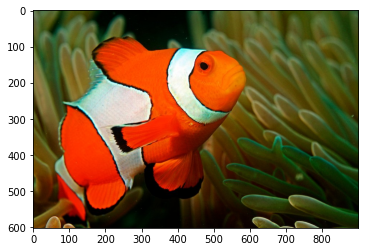

In [11]:
# load and show image 
nemo = cv2.imread('data/nemo_1.jpg')
nemo = cv2.cvtColor(nemo, cv2.COLOR_BGR2RGB) #why this line ?
show_image(nemo)

### Visualizing the Image color Clusters

#### In RGB
as you can see no obvious clusters that can be separated easily are formed

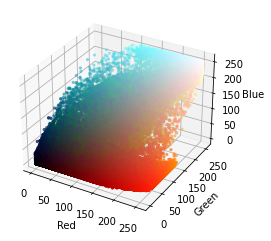

In [12]:
r, g, b = cv2.split(nemo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = nemo.reshape((np.shape(nemo)[0]*np.shape(nemo)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

#### In  HSV
In orange blue and white color clusters can be observed more easily

In [13]:
# convert color to hsv
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)

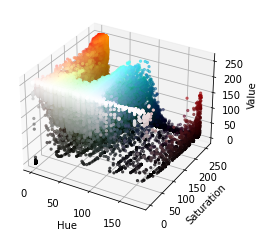

In [14]:
h, s, v = cv2.split(hsv_nemo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

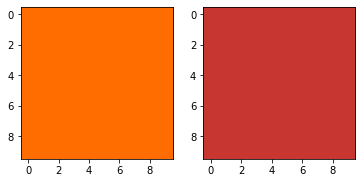

In [15]:
# pick selected color ranges and show them
light_orange = (1, 190, 200)
dark_orange = (18, 255, 255)

from matplotlib.colors import hsv_to_rgb
lo_square = np.full((10, 10, 3), light_orange, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark_orange, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

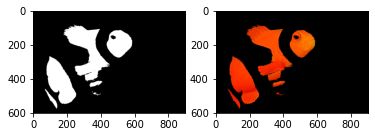

In [16]:
# filter selected range
mask = cv2.inRange(hsv_nemo, light_orange, dark_orange)
result = cv2.bitwise_and(nemo, nemo, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

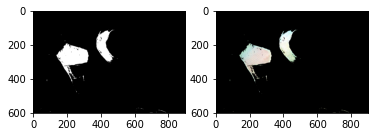

In [17]:
# get the whites too
light_white = (0, 0, 200)
dark_white = (145, 60, 255)













mask_white = cv2.inRange(hsv_nemo, light_white, dark_white)
result_white = cv2.bitwise_and(nemo, nemo, mask=mask_white)

plt.subplot(1, 2, 1)
plt.imshow(mask_white, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result_white)
plt.show()

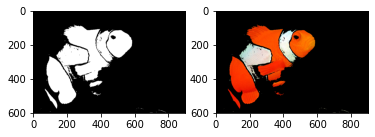

In [18]:
# add the masks
final_mask = mask + mask_white

final_result = cv2.bitwise_and(nemo, nemo, mask=final_mask)
plt.subplot(1, 2, 1)
plt.imshow(final_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(final_result)

plt.show()

### Histogram
A histogram represents the distribution of pixel intensities (whether color or grayscale) in an image. It can be visualized as a graph (or plot) that gives a high-level intuition of the intensity (pixel value) distribution.

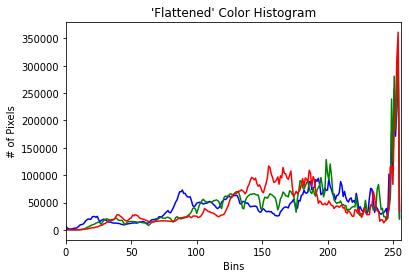

In [20]:
chans = cv2.split(image)
colors = ("b", "g", "r")
plt.figure()
plt.title("'Flattened' Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
# loop over the image channels
for (chan, color) in zip(chans, colors):
	# create a histogram for the current channel and plot it
	hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
	plt.plot(hist, color=color)
	plt.xlim([0, 256])

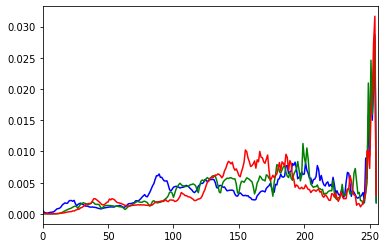

In [21]:
# normalize the histogram
# plot the normalized histogram
for (chan, color) in zip(chans, colors):
    # create a histogram for the current channel and plot it
    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    hist /= hist.sum()
    plt.plot(hist, color=color)
    plt.xlim([0, 256])

It is a method that improves the contrast in an image, in order to stretch out the intensity range
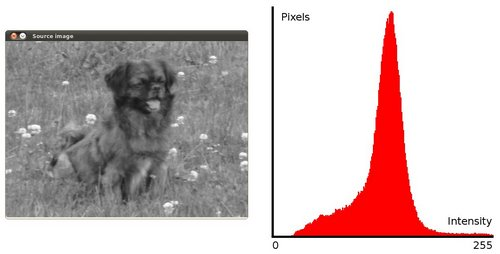

To make it clearer, from the image above, you can see that the pixels seem clustered around the middle of the available range of intensities. What Histogram Equalization does is to stretch out this range. Take a look at the figure below: The green circles indicate the underpopulated intensities. After applying the equalization, we get an histogram like the figure in the center. The resulting image is shown in the picture at right.

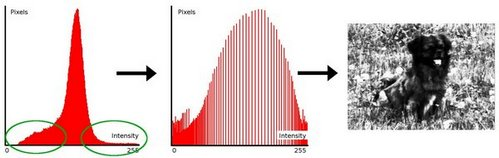



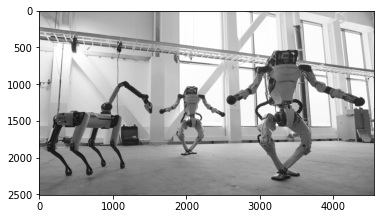

In [22]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
show_image(gray, grey=True)

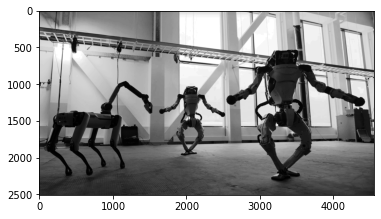

In [23]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# apply histogram equalization
equalized = cv2.equalizeHist(gray)
show_image(equalized,grey=True)

# Section 3: Transformations
Image transformation are basic linear algebra matrix operations

**Scaling**

Scaling is just resizing of the image. OpenCV comes with a function cv2.resize() for this purpose. The size of the image can be specified manually, or you can specify the scaling factor. Different interpolation methods are used. Preferable interpolation methods are cv2.INTER_AREA for shrinking and cv2.INTER_CUBIC (slow) & cv2.INTER_LINEAR for zooming. By default, interpolation method used is cv2.INTER_LINEAR for all resizing purposes. You can resize an input image either of following methods:

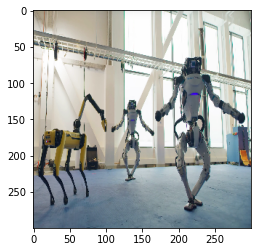

In [24]:
# resize image naievly
image_resized = cv2.resize(image, (300, 300))
show_image(image_resized)

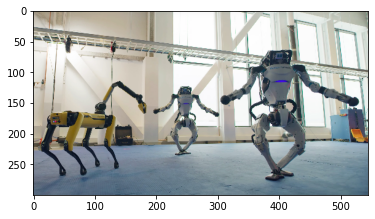

In [25]:
# resize keeping aspect ratio
h = 300
w = int(h*image.shape[1]/image.shape[0])
image_resized = cv2.resize(image, (w, h))
show_image(image_resized)

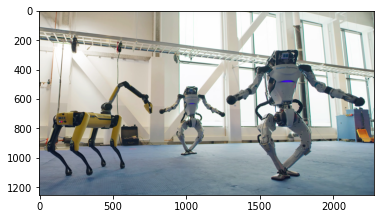

In [26]:
# resize using scaling factor
image_resized = cv2.resize(image,None,fx=0.5, fy=0.5)
show_image(image_resized)

**Translation**
Translation is the shifting of object’s location. If you know the shift in (x,y) direction, let it be (t_x,t_y), you can create the transformation matrixas follows:
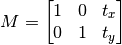

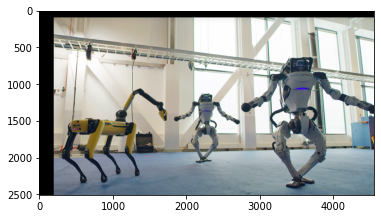

In [27]:
rows,cols,_ = image.shape

M = np.float32([[1,0,200],[0,1,100]])
translate_image = cv2.warpAffine(image,M,(cols,rows))
show_image(translate_image)

**Rotation**

Rotation of an image for an angle \theta is achieved by the transformation matrix of the form

M = \begin{bmatrix} cos\theta & -sin\theta \\ sin\theta & cos\theta   \end{bmatrix}

But OpenCV provides scaled rotation with adjustable center of rotation so that you can rotate at any location you prefer. Modified transformation matrix is given by

\begin{bmatrix} \alpha &  \beta & (1- \alpha )  \cdot center.x -  \beta \cdot center.y \\ - \beta &  \alpha &  \beta \cdot center.x + (1- \alpha )  \cdot center.y \end{bmatrix}

where:

\begin{array}{l} \alpha =  scale \cdot \cos \theta , \\ \beta =  scale \cdot \sin \theta \end{array}

To find this transformation matrix, OpenCV provides a function, cv2.getRotationMatrix2D. Check below example which rotates the image by 90 degree with respect to center without any scaling.

[[ 6.123234e-17  1.000000e+00  1.025000e+03]
 [-1.000000e+00  6.123234e-17  3.530000e+03]]


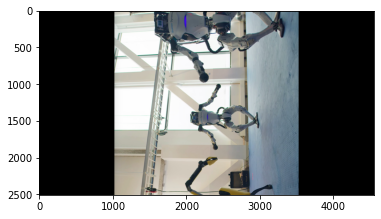

In [28]:
rows,cols,_ = image.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
print(M)
rotated_image = cv2.warpAffine(image,M,(cols,rows))
show_image(rotated_image)

**Affine Transformations**

In affine transformation, all parallel lines in the original image will still be parallel in the output image. affine transformation are a combination of all the previously defined transformations



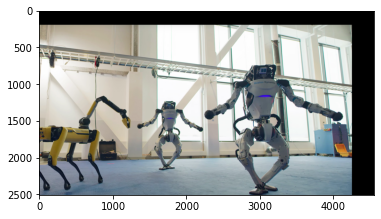

In [29]:
###### should we include affine transformation combining all
rows,cols,ch = image.shape

homography_matrix = np.array([[  1,   0      , -300],
       [ 0,   1.        ,  200]])

transformed_image = cv2.warpAffine(image,homography_matrix,(cols,rows))
show_image(transformed_image)